#Installation and initation


In [1]:
!pip3 install medpy

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import nibabel as nib
import matplotlib.pyplot as plt
import time
import json
%matplotlib inline


import cv2
from tqdm.notebook import tqdm
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from medpy.io import load


from PIL import Image

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
data_path = f'/content/drive/MyDrive/brainsightAI/NFBS_Dataset'
data_dirs = os.listdir(data_path)


In [5]:
#Set Hyperparameters and other config variables
class Config:
    """
    Holds configuration parameters
    """
    def __init__(self):
        self.name = "vanilla_unet"
        self.n_epochs = 10
        self.learning_rate = 0.0002
        self.batch_size = 40
        self.patch_size = 256
        self.transpose = [1,0,2]
        self.version = '1'
        self.test_results_dir = "/content/drive/MyDrive/brainsightAI/out"


c = Config()

In [6]:
vars(c)


{'batch_size': 40,
 'learning_rate': 0.0002,
 'n_epochs': 10,
 'name': 'vanilla_unet',
 'patch_size': 256,
 'test_results_dir': '/content/drive/MyDrive/brainsightAI/out',
 'transpose': [1, 0, 2],
 'version': '1'}

Going by the convention of nifti files download from NFBS 

In [7]:
data_list = []
for sub_dir in data_dirs:
    dir_contents = os.listdir(os.path.join(data_path,sub_dir))
    filename = sub_dir
    for file in dir_contents:
        if not 'brain' in file:
            image_path =  os.path.join(data_path,sub_dir,file)
        elif 'mask' in file:
            mask_path = os.path.join(data_path,sub_dir,file)
    data_list.append({'filename':filename,'image':image_path,'mask':mask_path})

print(len(data_list))
brain_volume_df = pd.DataFrame(data_list)
brain_volume_df.to_csv('/content/drive/MyDrive/brainsightAI/brain_volume_df.csv',index = False)

125


In [8]:
from IPython.display import clear_output
def slice_viewer_generator(dim, img, img_label):
    img_switcher = {
        0: lambda i: img[i,:,:],
        1: lambda i: img[:,i,:],
        2: lambda i: img[:,:,i]
    }
    img_label_switcher = {
        0: lambda i: img_label[i,:,:],
        1: lambda i: img_label[:,i,:],
        2: lambda i: img_label[:,:,i]
    }
    
    for s in range(img.shape[dim]):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        ax1.set_title('Image')
        ax2.set_title('Label')
        fig.suptitle(f'Viewing slice {s} along dimension {dim}')
        ax1.imshow(img_switcher[dim](s), cmap="gray")
        ax2.imshow(img_label_switcher[dim](s), cmap="gray")
        plt.show()
        clear_output(wait=True)
        yield

# EDA


In [ ]:
#Load the dataframe
brain_volume_df = pd.read_csv('/content/drive/MyDrive/brainsightAI/brain_volume_df.csv')
brain_volume_df.head(5)

,filename,image,mask
0,A00032875,/content/drive/MyDrive/brainsightAI/NFBS_Datas...,/content/drive/MyDrive/brainsightAI/NFBS_Datas...
1,A00033747,/content/drive/MyDrive/brainsightAI/NFBS_Datas...,/content/drive/MyDrive/brainsightAI/NFBS_Datas...
2,A00034854,/content/drive/MyDrive/brainsightAI/NFBS_Datas...,/content/drive/MyDrive/brainsightAI/NFBS_Datas...
3,A00028185,/content/drive/MyDrive/brainsightAI/NFBS_Datas...,/content/drive/MyDrive/brainsightAI/NFBS_Datas...
4,A00037511,/content/drive/MyDrive/brainsightAI/NFBS_Datas...,/content/drive/MyDrive/brainsightAI/NFBS_Datas...


In [ ]:
# Looking at a single volume
images = nib.load(brain_volume_df.loc[1]['image'])
masks = nib.load(brain_volume_df.loc[1]['mask'])
filename = brain_volume_df.loc[1]['filename']
print(filename)
image_volume = images.get_fdata()
mask_volume = masks.get_fdata()
# Since it is mentioned in NFBS site that voxels are of measurement 1mm3, I'll assume that it is true for all the volumes.
# Checking the allignment of images and masks

allign_diff = images.affine - masks.affine
print(allign_diff)

A00033747
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


Since the difference in affine of mask and images is zero, both volumes are properly aligned (assuming same is true for other volumes as this is a gold standard dataset)

In [ ]:
print(f"Image Shape:{image_volume.shape} , mask_shape:{mask_volume.shape}\n")
slicer = slice_viewer_generator(1,image_volume,mask_volume)



Image Shape:(256, 256, 192) , mask_shape:(256, 256, 192)



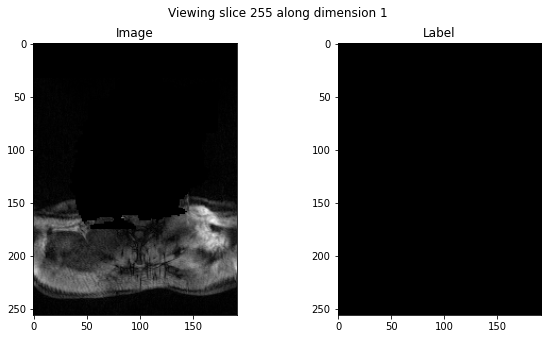

In [ ]:
 for slice in slicer:
     pass

Looking slices through each dimensions gave an interesting outcome,generally, MRIs primary axis tends to be axial, i.e to say slice dimension along axial axis tends to be symmetrical. But, for above volume, slice dimension along axial axis is (255,192). This might have happened due to the process of making voxel dimensions isometric (1mm3). Need to check, if is this the case for all the volumes? and do different volumes have different dimesnions?

As for checking the slices and their respective masks, i used slicer 3D tool to visualize the volume.

<img src="https://drive.google.com/uc?id=1SyBxDunduD_KNNm_zy7QeJa1Vbfj8BCG">

In [ ]:
# looking at the intensity profile of this particular volume
figure= plt.hist(image_volume.ravel())
plt.xlabel('Intensity')
plt.ylabel('Count')
print(np.amax(image_volume))

There is a huge number of black pixel , majorly due to padding and de-identification. Leaving low values aside, and checking distribution of intensity for different slices, distribution is more or less uniform.

In [ ]:
# Looking at all the volumes
# First checking the dimensions of all the volume, if we have an outlier or not
image_dim_dict = {}
mask_dim_dict = {}
for vol_ix in range(len(brain_volume_df)):
    image_dim = tuple(nib.load(brain_volume_df.loc[vol_ix]['image']).header['dim'][1:4])
    mask_dim = tuple(nib.load(brain_volume_df.loc[vol_ix]['mask']).header['dim'][1:4])
    image_dim_dict.setdefault(image_dim,[]).append(vol_ix)
    mask_dim_dict.setdefault(image_dim,[]).append(vol_ix)


In [ ]:
print(image_dim_dict.keys(), mask_dim_dict.keys()) 

All the volumes in dataset are of same volume. This will save us some steps in preprocessing pipeline

In [ ]:
#Checking the distribution of brain volume in out dataset, can become a metric of DNN model's performance
volumes = []
for vol_ix in range(len(brain_volume_df)):
    vol_ = np.count_nonzero(nib.load(brain_volume_df.loc[vol_ix]['mask']).get_fdata())
    volumes.append(vol_/1000)



In [ ]:
fig = plt.hist(volumes,bins=100)
plt.xlabel("volume in cm3")
plt.ylabel('count')

There are few volumes that are outside the general spread. 
Will inspect them and try to gain some more insight

In [ ]:
outlier = [] 
for vol_ix in range(len(brain_volume_df)):
    vol_ = np.count_nonzero(nib.load(brain_volume_df.loc[vol_ix]['mask']).get_fdata())
    if vol_/1000 > 1700 or vol_/1000 < 1050:
        outlier.append([vol_,brain_volume_df.loc[vol_ix]['filename']])

In [ ]:
outlier_sorted = sorted(outlier,key= lambda x : x[0])
print(outlier_sorted)

Checking these 4 volumes in 3D slicer ravels that all 4 volume are of head anatomically. Therefore, difference in volume might be due to different head size in the dataset populace.

EDA Summary
- All the volumes from the dataset are MRI of Human head anatomically.
- All the volumes are isometrically similar with voxels dimensions of 1mm3
- All the volumes are of same dimensions with their planes in following order [coronal,axial,sagittal] , need to reorder it before feeding it to model.
- All the volumes and their respiective masks are alligned properly.
- Brain tissue volume ranges from 1000 - 1800 cm3 for this dataset.This can be used as a performance metric 

with above information, i'll be using a 2D vanilla U-net architecture for segmenting brain tissues from the MRI volumes.Few pre-processing steps needs to applied for maintaining the input volume size.

# Build Vanilla U-net model

In [10]:

def conv_layer(input_channels, output_channels):     #This is a helper function to create the convolutional blocks
    conv = nn.Sequential(
        nn.Conv2d(input_channels, output_channels, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(output_channels, output_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(output_channels),
        nn.ReLU(inplace=True)
    )
    return conv

class UNet(nn.Module):
    def __init__(self,input_channel:int = 1,output_channel:int = 1):
        super(UNet, self).__init__()
        
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_1 = conv_layer(input_channel, 64)
        self.down_2 = conv_layer(64, 128)
        self.down_3 = conv_layer(128, 256)
        self.down_4 = conv_layer(256, 512)
        self.bottleneck = conv_layer(512, 1024)
        
        self.up_1 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=2, stride=2)
        self.up_conv_1 = conv_layer(1024, 512)
        self.up_2 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=2, stride=2)
        self.up_conv_2 = conv_layer(512, 256)
        self.up_3 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2)
        self.up_conv_3 = conv_layer(256, 128)
        self.up_4 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2)
        self.up_conv_4 = conv_layer(128, 64)
        
        self.output = nn.Conv2d(in_channels=64, out_channels=output_channel, kernel_size=1, padding=0)
        self.output_activation = nn.Softmax(dim=1)
                
    def forward(self, img):     #The print statements can be used to visualize the input and output sizes for debugging
        x1 = self.down_1(img)
        #print(x1.size())
        x2 = self.max_pool(x1)
        #print(x2.size())
        x3 = self.down_2(x2)
        #print(x3.size())
        x4 = self.max_pool(x3)
        #print(x4.size())
        x5 = self.down_3(x4)
        #print(x5.size())
        x6 = self.max_pool(x5)
        #print(x6.size())
        x7 = self.down_4(x6)
        #print(x7.size())
        x8 = self.max_pool(x7)
        #print(x8.size())
        x9 = self.bottleneck(x8)
        #print(x9.size())
        
        x = self.up_1(x9)
        #print(x.size())
        x = self.up_conv_1(torch.cat([x, x7], 1))
        #print(x.size())
        x = self.up_2(x)
        #print(x.size())
        x = self.up_conv_2(torch.cat([x, x5], 1))
        #print(x.size())
        x = self.up_3(x)
        #print(x.size())
        x = self.up_conv_3(torch.cat([x, x3], 1))
        #print(x.size())
        x = self.up_4(x)
        #print(x.size())
        x = self.up_conv_4(torch.cat([x, x1], 1))
        #print(x.size())
        
        x = self.output(x)
        x = self.output_activation(x)
        #print(x.size())
        
        return x

    

#Build data pipeline

In [11]:
split = {}
volume_df = pd.read_csv('/content/drive/MyDrive/brainsightAI/brain_volume_df.csv')
print(f"total volumes : {len(volume_df)}")
#splitting the volumes in three groups for train,validation and testing.
#splitting rather than splitting single scans makes sense, this way there wont be any data leakage between training and validation set

train_df,test_df = train_test_split(volume_df, test_size = 0.1,random_state=11)
train_df,val_df = train_test_split(train_df,test_size = 0.2,random_state=11)

print(f"training volumes:{len(train_df)}\nvalidation volumes:{len(val_df)}\ntesting volumes:{len(test_df)}\ntotal:{len(train_df)+len(val_df)+len(test_df)}")


split['train'] = train_df.head(10).reset_index(drop=True)
split['validation'] = val_df.head(10).reset_index(drop=True)
split['test'] = test_df.head(5).reset_index(drop=True)

split['train']

total volumes : 125
training volumes:89
validation volumes:23
testing volumes:13
total:125


,filename,image,mask
0,A00040628,/content/drive/MyDrive/brainsightAI/NFBS_Datas...,/content/drive/MyDrive/brainsightAI/NFBS_Datas...
1,A00057182,/content/drive/MyDrive/brainsightAI/NFBS_Datas...,/content/drive/MyDrive/brainsightAI/NFBS_Datas...
2,A00053455,/content/drive/MyDrive/brainsightAI/NFBS_Datas...,/content/drive/MyDrive/brainsightAI/NFBS_Datas...
3,A00058552,/content/drive/MyDrive/brainsightAI/NFBS_Datas...,/content/drive/MyDrive/brainsightAI/NFBS_Datas...
4,A00053475,/content/drive/MyDrive/brainsightAI/NFBS_Datas...,/content/drive/MyDrive/brainsightAI/NFBS_Datas...
5,A00040151,/content/drive/MyDrive/brainsightAI/NFBS_Datas...,/content/drive/MyDrive/brainsightAI/NFBS_Datas...
6,A00062288,/content/drive/MyDrive/brainsightAI/NFBS_Datas...,/content/drive/MyDrive/brainsightAI/NFBS_Datas...
7,A00060372,/content/drive/MyDrive/brainsightAI/NFBS_Datas...,/content/drive/MyDrive/brainsightAI/NFBS_Datas...
8,A00059344,/content/drive/MyDrive/brainsightAI/NFBS_Datas...,/content/drive/MyDrive/brainsightAI/NFBS_Datas...
9,A00062942,/content/drive/MyDrive/brainsightAI/NFBS_Datas...,/content/drive/MyDrive/brainsightAI/NFBS_Datas...


In [12]:
#pre-processing block

def med_reshape(image, new_shape):
    """
    This function reshapes 3D data to new dimension padding with zeros
    and leaving the content in the top-left corner

    Arguments:
        image {array} - 3D array of pixel data
        new_shape {3-tuple} - expected output shape

    Returns:
        3D array of desired shape, padded with zeroes
    """

    reshaped_image = np.zeros(new_shape)
    reshaped_image[0:image.shape[0],0:image.shape[1],0:image.shape[2]] = image    
    return reshaped_image




def normalize_and_scale(dataFrame,yShape:int=64,zShape:int=64,axes_shift = [0,1,2]):
    """
    This function loads our dataset form disk into memory,
    reshaping output to common size

    input arguments
    dataFrame - pandas dataframe containg image volume and mask volume paths

    returns
    Array of dictionaries with data stored in seg and image fields as 
        Numpy arrays of shape [AXIAL_WIDTH, Y_SHAPE, Z_SHAPE]
    """
    out = []
    for ix in range(len(dataFrame)):
        filename = dataFrame.loc[ix]['filename']
        images,_ = load(dataFrame.loc[ix]['image'])
        # images = nib.load(dataFrame.loc[ix]['image']).get_fdata()
        labels,_ = load(dataFrame.loc[ix]['mask'])

    # since we know from EDA that 1st dimension in the volume corresponds to axial axis
        images = images.transpose(axes_shift[0],axes_shift[1],axes_shift[2])
        labels = labels.transpose(axes_shift[0],axes_shift[1],axes_shift[2])
    
    #normalization
        max_val = np.amax(images)
        min_val = np.amin(images)
        images = (images-min_val)/(max_val - min_val)
        

   # reshaping the volume , so that every volume is of same size
        images = med_reshape(images, new_shape=(images.shape[0], yShape, zShape))
        labels = med_reshape(labels, new_shape=(labels.shape[0], yShape, zShape)).astype(int)


        mean = np.mean(images, axis=(0, 1, 2))
        std_dev = np.std(images, axis=(0, 1, 2))
        images = (images - mean) / std_dev
        
        out.append({'filename':filename,'image':images,'mask':labels})

    
    return np.array(out)



In [13]:
class stripDataset(Dataset):
    def __init__(self,config,dataFrame,transform=None):
        self.dataframe = dataFrame
        self.size = config.patch_size
        self.transpose = config.transpose
        self.slices = []
        self.transform = transform
        self.data = normalize_and_scale(self.dataframe,yShape=self.size,zShape=self.size,axes_shift=self.transpose)


        for i, d in enumerate(self.data):
            for j in range(d["image"].shape[0]):
                self.slices.append((i, j))
    

    def __getitem__(self,idx):
        
        slc = self.slices[idx]
        sample = dict()
        sample["id"] = idx
        img_volume = self.data[slc[0]]['image']
        label_volume = self.data[slc[0]]['mask']
        sample["image"] = torch.from_numpy(img_volume[slc[1]][None,:])
        sample["mask"] = torch.from_numpy(label_volume[slc[1]][None,:])
        return sample

    def __len__(self):
      return len(self.slices)


#Defining Performance metrices

In [14]:
def Dice3d(volume1, volume2):
    """
    This will compute the Dice Similarity coefficient for two 3-dimensional volumes
    Arguments:
        a {Numpy array} -- 3D array with first volume
        b {Numpy array} -- 3D array with second volume

    Returns:
        float
    """
    if len(volume1.shape) != 3 or len(volume2.shape) != 3:
        raise Exception(f"Expecting 3 dimensional inputs, got {volume1.shape} and {volume2.shape}")

    if volume1.shape != volume2.shape:
        raise Exception(f"Expecting inputs of the same shape, got {volume1.shape} and {volume2.shape}")

    volume1 = (volume1>0).astype(np.int)
    volume2 = (volume2>0).astype(np.int)
    
    intersection = np.sum(volume1*volume2)
    vol_sum = np.sum(volume1) + np.sum(volume2)
    
    if vol_sum == 0:
        return -1
    return 2*(float(intersection)/float(vol_sum))

def Jaccard3d(a, b):
    """
    This will compute the Jaccard Similarity coefficient for two 3-dimensional volumes
    

    Arguments:
        a {Numpy array} -- 3D array with first volume
        b {Numpy array} -- 3D array with second volume

    Returns:
        float
    """
    if len(a.shape) != 3 or len(b.shape) != 3:
        raise Exception(f"Expecting 3 dimensional inputs, got {a.shape} and {b.shape}")

    if a.shape != b.shape:
        raise Exception(f"Expecting inputs of the same shape, got {a.shape} and {b.shape}")
        
    a = (a>0).astype(np.int)
    b = (b>0).astype(np.int)
    
    intersection = np.sum(a*b)
    vol_sum = np.sum(a) + np.sum(b)
    
    if vol_sum == 0:
        return -1
    return (float(intersection)/float(vol_sum - intersection))


#Training/validation Life cycle

In [15]:
class train_and_validate:
    """ This class implements the basic life cycle of segmentation task
         Basic Life cycle is :
         run():
              for epoch in n_epoch:
                train()
                validate()
         test()
    """
    def __init__(self,config,split):
        self.n_epochs = config.n_epochs
        self.version = config.version
        self.split = split
        self._time_start = ""
        self._time_end = ""
        self.epoch = 0
        self.name = config.name
        self.reshape_size = config.patch_size
        self.batch_size = config.batch_size
        self.transpose = config.transpose


        dirname = f"{self.name}_{self.version}"
        self.out_dir = os.path.join(config.test_results_dir, dirname)
        os.makedirs(self.out_dir, exist_ok=True)


        self.train_loader = DataLoader(stripDataset(config,split['train']),batch_size=self.batch_size, shuffle=True, num_workers=4)
        self.val_loader = DataLoader(stripDataset(config,self.split['validation']),batch_size=self.batch_size, shuffle=True, num_workers=4)
        
        self.test_df = self.split['test']

        if not torch.cuda.is_available():
            print("WARNING: No CUDA device is found. This may take significantly longer!")
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.model = UNet(input_channel=1,output_channel=2)
        self.model.to(self.device)

        self.loss_function = torch.nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=config.learning_rate)
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, 'min')


    def train(self):

        train_losses = []

        print(f"Training epoch {self.epoch}...")
        self.model.train()
        
        loop = tqdm(enumerate(self.train_loader),total = len(self.train_loader),leave = False)
        for i,batch in loop:
            self.optimizer.zero_grad()
            data = batch['image'].float().to(self.device)
            target = batch['mask'].to(self.device)

            prediction = self.model(data)
            loss = self.loss_function(prediction, target[:,0,:,:])
            loss.backward()
            self.optimizer.step()

            train_losses.append(loss.item())


        
        print(f"\nTraining complete for epoch:{self.epoch}")
        return train_losses

    def validate(self):

        self.model.eval()
        print(f"Validating epoch {self.epoch}...")

        validation_losses = []
        dice_coeff = []
        with torch.no_grad():
            loop = tqdm(enumerate(self.val_loader),total = len(self.val_loader),leave = False)
            for i ,batch in loop:
            
                data = batch['image'].float().to(self.device)
                target = batch['mask'].to(self.device)
                  
                prediction = self.model(data)
                loss = self.loss_function(prediction, target[:,0,:,:])
                validation_losses.append(loss.item())


        # self.scheduler.step(np.mean(validation_losses))
        print(f"\n validation complete for epoch:{self.epoch}")
        return validation_losses

    def save_model_parameters(self):
        """
        Saves model parameters to a file in results directory
        """
        path = os.path.join(self.out_dir, "model.pth")

        torch.save(self.model.state_dict(), path)

    def load_model_parameters(self, path=''):
        """
        Loads model parameters from a supplied path or a
        results directory
        """
        if not path:
            model_path = os.path.join(self.out_dir, "model.pth")
        else:
            model_path = path

        if os.path.exists(model_path):
            self.model.load_state_dict(torch.load(model_path))
        else:
            raise Exception(f"Could not find path {model_path}")
    


    def run(self):

        self._time_start = time.time()
        for self.epoch in range(self.n_epochs):
            train_loss = self.train()
            val_loss = self.validate()
            self.save_model_parameters()
            print(f"for epoch:{self.epoch} - train loss:{np.mean(train_loss)}\tvalidation_loss:{np.mean(val_loss)}")
        
        self._time_end = time.time()
        

    def run_test(self):

        self.model.eval()
        test_volumes = normalize_and_scale(self.test_df,self.reshape_size,self.reshape_size,self.transpose)
        # print(f"test_volume shape{test_volumes.shape}")
        out_dict = {}
        out_dict["volume_stats"] = []
        dc_list = []
        jc_list = []
        for i, volume in enumerate(test_volumes):
            slices = []
            for slice_ in volume['image']:
                slice_ = torch.from_numpy(slice_[None,None,:,:]).type(torch.FloatTensor).to(self.device)
                pred = np.squeeze(self.model(slice_).cpu().detach())
                mask = torch.argmax(pred,dim=0).numpy()
                slices.append(mask)
            pred_label = np.array(slices)
                
            dice_ = Dice3d(pred_label,volume['mask'])
            jaccard_ = Jaccard3d(pred_label,volume['mask'])

            dc_list.append(dice_)
            jc_list.append(jaccard_)

            out_dict["volume_stats"].append({
            "filename": volume['filename'],
            "dice": dice_,
            "jaccard": jaccard_
            })

            print(f"{volume['filename']} Dice {dice_:.4f}. {100*(i+1)/len(self.test_df):.2f}% complete")
        
        
        out_dict["overall"] = {
            "mean_dice": np.mean(dc_list),
            "mean_jaccard": np.mean(jc_list)}
        print("\nTesting complete.")
        return out_dict



#Model training

In [16]:
#initiate the training class
process = train_and_validate(c,split)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
process.run()
result_json = process.run_test()
result_json["config"] = vars(c)

with open(os.path.join(process.out_dir, "results.json"), 'w') as out_file:
        json.dump(result_json, out_file, indent=2, separators=(',', ': '))

Training epoch 0...


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Training complete for epoch:0
Validating epoch 0...



 validation complete for epoch:0
for epoch:0 - train loss:0.43086716439574957	validation_loss:0.4335137838497758
Training epoch 1...



Training complete for epoch:1
Validating epoch 1...



 validation complete for epoch:1
for epoch:1 - train loss:0.3666974254883826	validation_loss:0.35562150925397873
Training epoch 2...



Training complete for epoch:2
Validating epoch 2...



 validation complete for epoch:2
for epoch:2 - train loss:0.34884938411414623	validation_loss:0.34372904896736145
Training epoch 3...



Training complete for epoch:3
Validating epoch 3...



 validation complete for epoch:3
for epoch:3 - train loss:0.3390519618988037	validation_loss:0.34265236649662256
Training epoch 4...



Training complete for epoch:4
Validating epoch 4...



 validation complete for epoch:4
for epoch:4 - train loss:0.33307653246447444	validation_loss:0.33095316402614117
Training epoch 5...



Training complete for epoch:5
Validating epoch 5...



 validation complete for epoch:5
for epoch:5 - train loss:0.3291305033490062	validation_loss:0.33422448113560677
Training epoch 6...



Training complete for epoch:6
Validating epoch 6...



 validation complete for epoch:6
for epoch:6 - train loss:0.32636434864252806	validation_loss:0.3267276668921113
Training epoch 7...



Training complete for epoch:7
Validating epoch 7...



 validation complete for epoch:7
for epoch:7 - train loss:0.3243048503063619	validation_loss:0.32354859774932265
Training epoch 8...



Training complete for epoch:8
Validating epoch 8...



 validation complete for epoch:8
for epoch:8 - train loss:0.32257437193766236	validation_loss:0.3230139072984457
Training epoch 9...



Training complete for epoch:9
Validating epoch 9...



 validation complete for epoch:9
for epoch:9 - train loss:0.3215191881172359	validation_loss:0.3215971156023443
A00055763 Dice 0.9770. 20.00% complete
A00034854 Dice 0.9768. 40.00% complete
A00057786 Dice 0.9758. 60.00% complete
A00037112 Dice 0.9422. 80.00% complete
A00038998 Dice 0.9780. 100.00% complete

Testing complete.


#Visualization

In [17]:
def load_model_parameters(model, path=''):
        """
        Loads model parameters from a supplied path or a
        results directory
        """
        model_path = path

        if os.path.exists(model_path):
            model.load_state_dict(torch.load(model_path))
        else:
            raise Exception(f"Could not find path {model_path}")

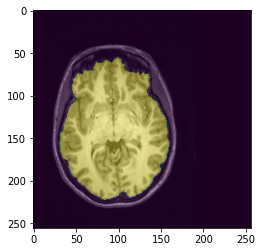

In [ ]:
# image_path = "/content/drive/MyDrive/brainsightAI/NFBS_Dataset/A00057786/sub-A00057786_ses-NFB3_T1w.nii.gz"
# mask_path = "/content/drive/MyDrive/brainsightAI/NFBS_Dataset/A00057786/sub-A00057786_ses-NFB3_T1w_brainmask.nii.gz"
# filename = 'A00057786'


pred_masks = []

bd_df = pd.DataFrame({'filename':filename,'image':image_path,'mask':mask_path},index=[0])
bd_out = normalize_and_scale(bd_df,256,256,[1,0,2])
ori_mask = bd_out[0]['mask']
model1 = process.model

load_model_parameters(model1,path = process.out_dir+'/model.pth')

model1.eval()
model1.to(process.device)
plt.imshow(bd_out[0]['image'][100],cmap='gray')
plt.imshow(bd_out[0]['mask'][100],alpha=0.4)

In [ ]:

for img in bd_out[0]['image']:
    img = torch.from_numpy(img[None,None,:,:]).type(torch.FloatTensor).to(process.device)
    pred_ = np.squeeze(model1(img).cpu().detach())
    mask_ = torch.argmax(pred_,dim=0).numpy()
    pred_masks.append(mask_)
pred_masks = np.array(pred_masks)
print(pred_masks.shape,bd_out[0]['mask'].shape)



(256, 256, 256) (256, 256, 256)


In [ ]:
slicer1 = slice_viewer_generator(0,ori_mask,pred_masks)

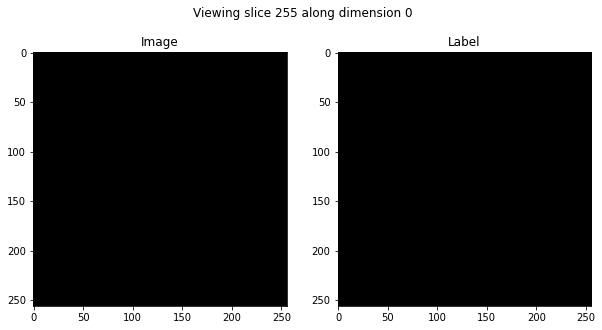

In [ ]:
for slice in slicer1:
    pass

Loose inference visualisation

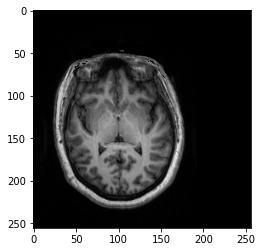

In [18]:
imag_path = "/content/drive/MyDrive/brainsightAI/T1Img/sub-02/anat_img.nii.gz"
dummy_mask_path = mask_path = "/content/drive/MyDrive/brainsightAI/NFBS_Dataset/A00057786/sub-A00057786_ses-NFB3_T1w_brainmask.nii.gz"
filename1 = 'sub-01'
inf_df = pd.DataFrame({'filename':filename,'image':image_path,'mask':mask_path},index=[0])

inf_out = normalize_and_scale(inf_df,256,256,[1,0,2])
model2 = process.model

load_model_parameters(model2,path = process.out_dir+'/model.pth')

model2.eval()
model2.to(process.device)
plt.imshow(inf_out[0]['image'][100],cmap='gray')




In [ ]:
inf_masks = []
for img in inf_out[0]['image']:
    img = torch.from_numpy(img[None,None,:,:]).type(torch.FloatTensor).to(process.device)
    pred_inf = np.squeeze(model2(img).cpu().detach())
    mask_inf = torch.argmax(pred_inf,dim=0).numpy()
    inf_masks.append(mask_inf)
inf_masks = np.array(inf_masks)
print(inf_masks.shape,inf_out[0]['image'].shape)

(256, 256, 256) (256, 256, 256)


In [ ]:
slicer2 = slice_viewer_generator(1,inf_out[0]['image'],inf_masks)

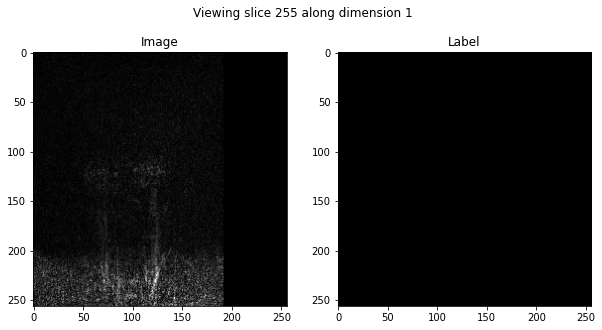

In [ ]:
for slice in slicer2:
    pass

#Inference

This section will deal with unknown volumes and output masks and segmented brain slices....ideally.



In [37]:
# I checked the test volumes in 3D slicer to figure out the axis of axial plane. This could be done through volumes affine attribute.

class infer_config:
     
     def __init__(self):
        self.name = "vanilla_unet"
        self.device = 'cuda'
        self.transpose = [1,0,2]
        self.version = '1'
        self.test_results_dir = "/content/drive/MyDrive/brainsightAI/out"
        self.parameter_file = 'model.pth'
        self.infer_path = '/content/drive/MyDrive/brainsightAI/T1Img'
        self.infer_file = 'sub-04/T1w MRI.nii'
        self.reshape_size = 256


c1 = infer_config()

def Inference(model,config):
    device = config.device
    infer_model = model
    parameter_path = os.path.join(config.test_results_dir,config.name+'_'+config.version,config.parameter_file)
    volume_path = os.path.join(config.infer_path,config.infer_file)
    # infer_model.load_state_dict(torch.load(parameter_path))
    load_model_parameters(infer_model,parameter_path)
    infer_model.eval()
    infer_model.to(device)
    ori_volume = nib.load(volume_path)
    affine = ori_volume.affine
    volume = ori_volume.get_fdata()
    header = ori_volume.header
    reshape_size = config.reshape_size

    axes_shift = config.transpose
    max_val = np.amax(volume)
    min_val = np.amin(volume)
    volume = (volume - min_val)/(max_val - min_val)

    volume = volume.transpose(axes_shift[0],axes_shift[1],axes_shift[2])
    volume = med_reshape(volume, new_shape=(volume.shape[0], reshape_size, reshape_size)) 
    mean = np.mean(volume, axis=(0, 1, 2))
    std_dev = np.std(volume, axis=(0, 1, 2))
    volume = (volume - mean) / std_dev

    infer_masks = []
    
    for slice in volume:
        img = torch.from_numpy(slice[None,None,:,:]).type(torch.FloatTensor).to(device)
        pred_inf = np.squeeze(model(img).cpu().detach())
        mask_inf = torch.argmax(pred_inf,dim=0).numpy()
        infer_masks.append(mask_inf)
    
    inf_masks = np.array(infer_masks)   
    print(volume.shape)
    ss_volume = np.multiply(volume,inf_masks)
    print(ss_volume.shape)
    ss_volume_nii = nib.Nifti1Image(ss_volume,affine)
    ss_mask_nii = nib.Nifti1Image(inf_masks,affine)

    file_infer = config.infer_file.split('.')[0]
    print(file_infer)
    nib.save(ss_volume_nii,os.path.join(config.infer_path,file_infer+'_brain.nii.gz'))
    nib.save(ss_mask_nii,os.path.join(config.infer_path,file_infer+'_brainmask.nii.gz'))


In [38]:
c1.transpose = [1,0,2]
model_infer = process.model
Inference(model_infer,c1)


ValueError: ignored